# Assignment 1: Best practices for data science reproducibility with Wikipedia data example. 

This notebook will call APIs (described in readme) to collect page hit data from the english wikipedia site, then save, clean, reformat data into a csv. It will then generate a visualization of monthly counts from all data sources split by mobile and desktop hits. Any questions can be sent to drslob@gmail.com

## Required packages
- numpy (https://numpy.org/)
- pandas (https://pandas.pydata.org/)
- matplotlib (https://matplotlib.org/)

## The Data used in this notebook was collected from wikimedia REST API 
- https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts
- https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews

license: CC-BY-SA 3.0 and GFDL licenses (https://creativecommons.org/licenses/by-sa/3.0/, https://www.gnu.org/licenses/fdl-1.3.html)

Terms of use: https://www.mediawiki.org/wiki/REST_API#Terms_and_conditions


In [252]:
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter

## The above code was stolen from (http://paws-public.wmflabs.org/paws-public/User:Jtmorgan/data512_a1_example.ipynb)\

In [253]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [254]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

## The code below sets the parameters to grab legacy counts on en.wikipedia.org on a monthly basis throughout its entire date range for both desktop and mobile clicks

In [255]:
headers = {
    'User-Agent': 'https://github.com/bogyshi',
    'From': 'avanroi1@uw.edu'
}

legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",#december 07 to july 16
                 "end" : "2016073100"
                    }
legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",#december 07 to july 16
                 "end" : "2016073100"
                    }



## The code below sets the parameters to grab pageview counts on en.wikipedia.org on a monthly basis throughout its entire date range for both desktop, mobile web, and mobile app clicks

Note: We can filter out web scrapers and crawlers from these counts, unlike our legacy page counts!

In [256]:
pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",#july2015 to august 2019
                    "end" : '2019083100'
                        }
pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",#july2015 to august 2019
                    "end" : '2019083100'
                        }
pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",#july2015 to august 2019
                    "end" : '2019083100'
                        }

## Now we grab the data

In [257]:
legacy_desktop_data = api_call(endpoint_legacy, legacy_desktop)
legacy_mobile_data = api_call(endpoint_legacy, legacy_mobile)

pageviews_desktop_data = api_call(endpoint_pageviews,pageviews_desktop)
pageviews_mobile_web_data = api_call(endpoint_pageviews,pageviews_mobile_web)
pageviews_mobile_app_data = api_call(endpoint_pageviews,pageviews_mobile_app)


## Now the data is saved locally

In [258]:
legacy_desktop_fname = "pagecounts_desktop-site_200712-201607.json"
legacy_mobile_fname = "pagecounts_mobile-site_200712-201607.json"
pageviews_desktop_fname = "pageviews_desktop_201507-201908.json"
pageviews_mobile_web_fname = "pageviews_mobile_web_201507-201908.json"
pageviews_mobile_app_fname = "pageviews_mobile_app_201507-201908.json"

fs = [legacy_desktop_fname,legacy_mobile_fname,pageviews_desktop_fname,pageviews_mobile_web_fname,pageviews_mobile_app_fname]
ds = [legacy_desktop_data,legacy_mobile_data,pageviews_desktop_data,pageviews_mobile_web_data,pageviews_mobile_app_data]
countColNames = ['desktop_count','mobile_count','desktop_view','mobile_web_view','mobile_app_view']
counter = 0
for f in fs:
    with open(f, 'w') as outfile:
        json.dump(ds[counter], outfile)
    counter+=1

## Below we convert our raw api data into one large csv
We achieve this in the following order
- create pandas data frame for each raw api call
- do an  outer join on the timestamp for each new dataframe
- fill in NA columns with zeros
- create aggregates on desktop, mobile counts for both legacy and pageview counts

In [259]:
dfs=[]
counter=0
stdf=None
for d in ds:
    ta =  pd.DataFrame(d['items'])
    if(counter<2):
        ta[countColNames[counter]]=ta['count']
        ta=ta.drop(['granularity','project','access-site','count'],axis=1)

    else:
        ta[countColNames[counter]]=ta['views']
        ta=ta.drop(['agent','granularity','project','access','views'],axis=1)
    ta['timestamp'] = (pd.to_datetime(ta['timestamp'],format='%Y%m%d%S'))
    ta=ta.set_index('timestamp')
    if(stdf is None):
        stdf = ta
    else:
        dfs.append(ta)
    counter+=1

for d in dfs:
    stdf= stdf.join(d,on="timestamp",how='outer',rsuffix='_other')
stdf = stdf.fillna(0)
stdf['pagecount_all_views'] = stdf['desktop_count']+stdf['mobile_count']
stdf['pagecount_desktop_views'] = stdf['desktop_count']
stdf['pagecount_mobile_views'] = stdf['mobile_count']
stdf['pageview_desktop_views'] = stdf['desktop_view']
stdf['pageview_mobile_views'] = stdf['mobile_web_view']+stdf['mobile_app_view']
stdf['pageview_all_views'] = stdf['pageview_desktop_views']+stdf['pageview_mobile_views']
stdf = stdf.drop(countColNames,axis=1)
stdf['year'] = pd.DatetimeIndex(stdf.index).year
stdf['month'] = pd.DatetimeIndex(stdf.index).month
#stdf=stdf.set_index(['year','month'])
stdf = stdf.reset_index()
stdf = stdf.drop('timestamp',axis=1)


In [260]:
stdf

,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_desktop_views,pageview_mobile_views,pageview_all_views,year,month
0,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2007,12
1,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008,1
2,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008,2
3,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008,3
4,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008,4
5,5.584691e+09,5.584691e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008,5
6,5.712104e+09,5.712104e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008,6
7,5.306303e+09,5.306303e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008,7
8,5.140156e+09,5.140156e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008,8
9,5.479534e+09,5.479534e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00,2008,9


## We now save the data locally to a csv file

In [261]:
stdf.to_csv('en-wikipedia_traffic_200712-201908.csv',index=False)

## Lets visualize this data with matplotlib

In [262]:
tdf = stdf

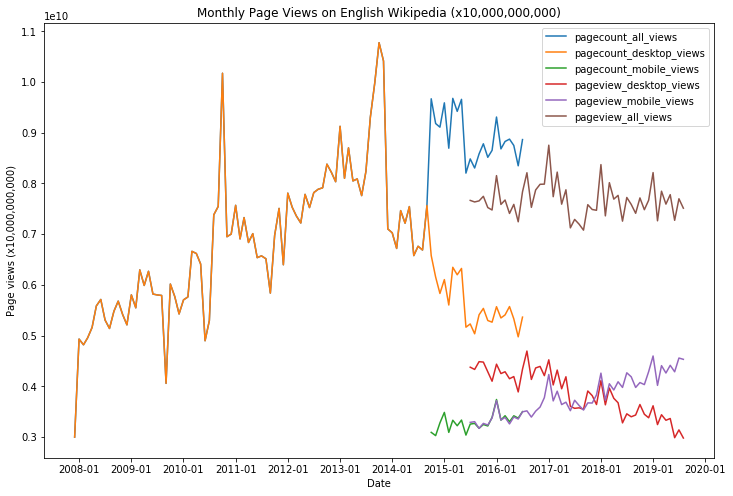

In [265]:
fig, ax = plt.subplots(figsize=(12, 8))
tdf['date'] = tdf['year'].map(str)+ '-' +tdf['month'].map(str)
tdf['date'] = pd.to_datetime(tdf['date'], format='%Y-%m')
xs = tdf['date']
tdf = tdf.replace({0:np.nan})
ys = tdf.drop(['year','month','date'],axis=1)

for yd in ys:
    yn = ys[yd]
    ax.plot(xs,yn,label=yd)
    counter+=1
#ax.plot(xs,ys,label=legNames)
ax.set(xlabel="Date", ylabel="Page views (x10,000,000,000)",
       title="Monthly Page Views on English Wikipedia (x10,000,000,000)")

# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.legend()
fig1 = plt.gcf()
plt.show()


## Now we will save the image above

In [264]:
fig1.savefig('EN_WIKI_VIEWS.png', dpi=300,quality=95)